# Calculate RMSSD

## For each trial

In [9]:
import numpy as np
import pandas as pd
import json
import matplotlib.pyplot as plt

def rmssd_from_rr(rr_ms: pd.Series) -> float:
    rr = rr_ms.dropna().values.astype(float)
    if len(rr) < 2:
        return np.nan
    diff = np.diff(rr)
    return np.sqrt(np.mean(diff**2))

# load merged experiment JSON
with open("experiment_data_with_hr.json", "r", encoding="utf-8") as f:
    participants = json.load(f)

# rows
rows = []
for p in participants:
    pid = p["participant_id"]

    for stim in p["stimuli"]:
        vid_id = stim["video_id"]
        stim_id = stim["id"]

        hr_rows = stim.get("heart_rate", [])
        if not hr_rows:
            rmssd_ms = np.nan
        else:
            df_hr = pd.DataFrame(hr_rows)

            if "ArtifactCorrectedRR" not in df_hr.columns or "ts" not in df_hr.columns:
                rmssd_ms = np.nan
            else:
                df_hr["ts"] = pd.to_datetime(df_hr["ts"], errors="coerce")
                df_hr = df_hr.dropna(subset=["ts", "ArtifactCorrectedRR"]).sort_values("ts")

                rmssd_ms = rmssd_from_rr(df_hr["ArtifactCorrectedRR"])

        # participant's belief from JSON
        belief = stim.get("video_response", {}).get("belief")

        rows.append({
            "participant_id": pid,
            "stim_id": stim_id,
            "video_id": vid_id,
            "belief": belief.strip(),
            "RMSSD_ms": rmssd_ms,
            "RMSSD_seconds": rmssd_ms / 1000.0 if pd.notna(rmssd_ms) else np.nan,
        })

rmssd_df = pd.DataFrame(rows)
rmssd_df.to_csv("rmssd_per_video.csv", index=False)

rmssd_df


,participant_id,stim_id,video_id,belief,RMSSD_ms,RMSSD_seconds
0,1,1,4171487-uhd_3840_2160_30fps.mp4,Human Generated,6.574545,0.006575
1,1,2,5768645-uhd_3840_2160_25fps.mp4,Human Generated,3.438652,0.003439
2,1,3,18840567-hd_1920_1080_30fps.mp4,AI Generated,9.947126,0.009947
3,1,4,11946387_3840_2160_30fps.mp4,AI Generated,11.292927,0.011293
4,2,1,4171487-uhd_3840_2160_30fps.mp4,Human Generated,9.658932,0.009659
...,...,...,...,...,...,...
83,22,4,5768645-uhd_3840_2160_25fps.mp4,AI Generated,56.831514,0.056832
84,23,1,18840567-hd_1920_1080_30fps.mp4,Human Generated,22.854238,0.022854
85,23,2,11946387_3840_2160_30fps.mp4,Human Generated,20.940313,0.020940
86,23,3,5768645-uhd_3840_2160_25fps.mp4,AI Generated,18.141420,0.018141


## Within subjects 

In [10]:
# Compute participant-level means
mean_table = (
    rmssd_df
    .pivot_table(
        index="participant_id",
        columns="belief",
        values="RMSSD_ms",
        aggfunc="mean"
    )
)

# Compute within-subject difference
mean_table["diff"] = (
    mean_table["AI Generated"] - mean_table["Human Generated"]
)

mean_table.to_csv("rmssd_per_participant.csv")

mean_table.head()

belief,AI Generated,Human Generated,diff
participant_id,,,
1,10.620026,5.006598,5.613428
2,3.578088,9.311638,-5.733550
3,6.638202,8.779479,-2.141277
4,8.045195,8.636253,-0.591058
5,34.008383,32.273139,1.735244


# Distribution of data (raincloud)

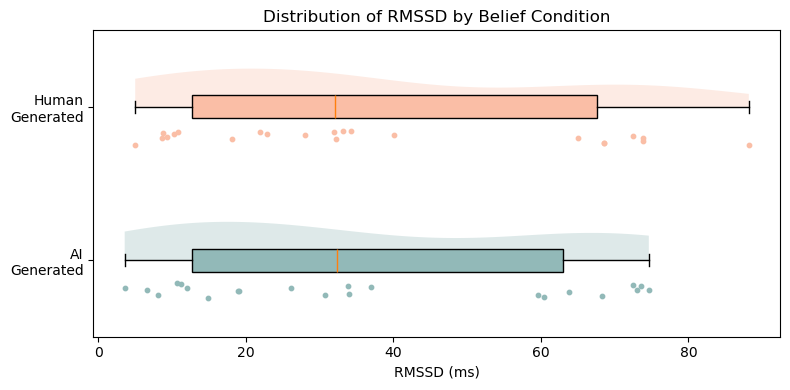

In [11]:
# Helper function to hide the top part of the violin plot and color them
def violin_to_distribution(vp, colors):
    for idx, b in enumerate(vp['bodies']):
        # Modify it so we only see the upper half of the violin plot
        b.get_paths()[0].vertices[:, 1] = np.clip(b.get_paths()[0].vertices[:, 1], idx+1, idx+2)
        # Change the color
        b.set_facecolor(colors[idx])

# Data to plot
data = [mean_table['AI Generated'], mean_table['Human Generated']]
colors = ["#92B9B8", "#FABEA6"]

fig, ax = plt.subplots(figsize=(8,4))

# Plot boxplot
bp = ax.boxplot(data, patch_artist = True, vert = False)
for patch, color in zip(bp['boxes'], colors):
    patch.set_facecolor(color)

# Plot distribution (violin plot)
vp = ax.violinplot(data, points = 500, showmeans=False, showextrema=False, showmedians=False, vert=False); 
violin_to_distribution(vp, colors)

# Plot individual points (scatter plot)
for idx, features in enumerate(data):
    y = np.full(len(features), idx + .8)    # Move the points below the other plots
    idxs = np.arange(len(y))
    y = y.astype(float)
    y.flat[idxs] += np.random.uniform(low=-.05, high=.05, size=len(idxs))
    plt.scatter(features, y, s=10, c=colors[idx])

plt.yticks([1, 2], ['AI\nGenerated', 'Human\nGenerated'])
plt.xlabel('RMSSD (ms)')
plt.title('Distribution of RMSSD by Belief Condition')
plt.tight_layout()
plt.show()

# Check for normal distribution

### Plot the distribution

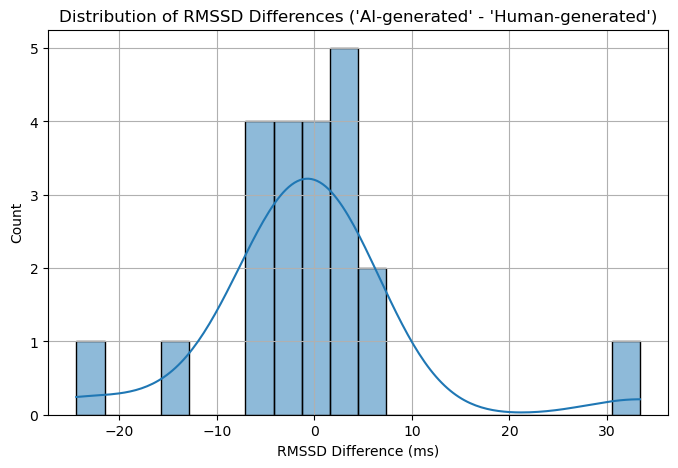

In [12]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(8,5))
sns.histplot(mean_table['diff'], kde=True, bins=20)
plt.title("Distribution of RMSSD Differences ('AI-generated' - 'Human-generated')")
plt.xlabel("RMSSD Difference (ms)")
plt.ylabel("Count")
plt.grid(True)
plt.show()


### 4. Shapiro–Wilk Normality Test

In [13]:
from scipy.stats import shapiro

stat, p = shapiro(mean_table['diff'])

print(f"Shapiro-Wilk Test statistic: {stat:.4f}")
print(f"p-value: {p:.4f}")

if p > 0.05:
    print("✔ Differences appear normally distributed (fail to reject H0)")
else:
    print("✖ Differences are NOT normally distributed (reject H0)")


Shapiro-Wilk Test statistic: 0.8167
p-value: 0.0009
✖ Differences are NOT normally distributed (reject H0)


### QQ Plot for RMSSD Differences

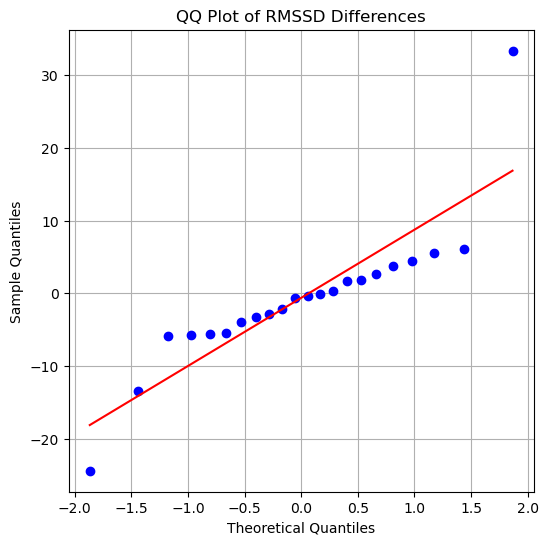

In [14]:
import scipy.stats as stats
import matplotlib.pyplot as plt

plt.figure(figsize=(6, 6))
stats.probplot(mean_table['diff'], dist="norm", plot=plt)
plt.title("QQ Plot of RMSSD Differences")
plt.xlabel("Theoretical Quantiles")
plt.ylabel("Sample Quantiles")
plt.grid(True)
plt.show()


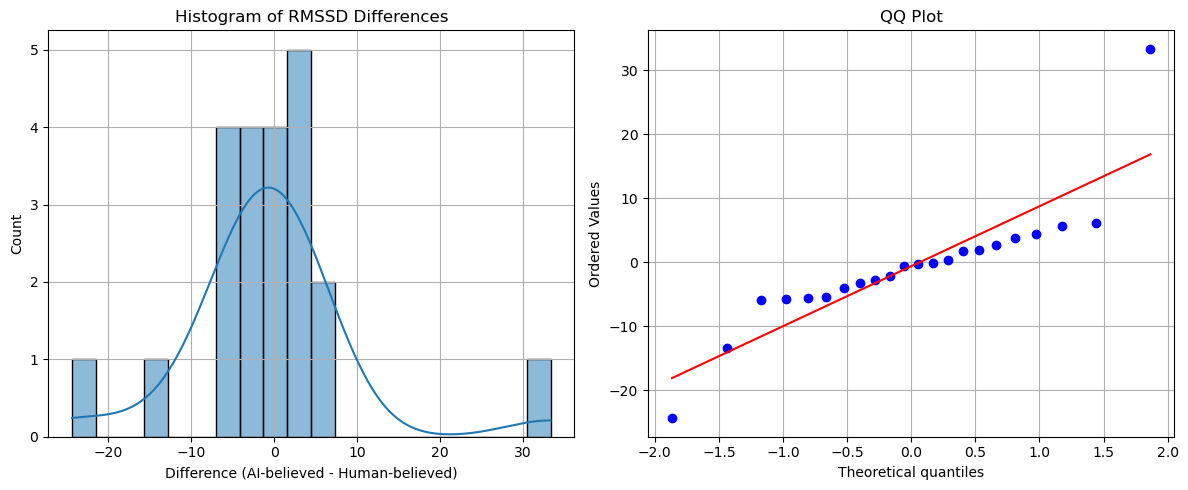

n = 22
Wilcoxon W = 102.000, p = 0.4434
approx. z = -0.795, effect size r = -0.170
median AI = 32.323, median Human = 32.109, median(AI - Human) = -0.463


In [15]:
from scipy.stats import wilcoxon

fig, ax = plt.subplots(1, 2, figsize=(12, 5))

# Histogram + KDE
sns.histplot(mean_table['diff'], kde=True, ax=ax[0], bins=20)
ax[0].set_title("Histogram of RMSSD Differences")
ax[0].set_xlabel("Difference (AI-believed - Human-believed)")
ax[0].grid(True)

# QQ Plot
stats.probplot(mean_table['diff'], dist="norm", plot=ax[1])
ax[1].set_title("QQ Plot")
ax[1].grid(True)

plt.tight_layout()
plt.show()

# --- Add Wilcoxon signed-rank test on participant-level means ---

# use pivot result
# mean_table is created earlier in this notebook
paired = mean_table[["AI Generated", "Human Generated"]].dropna()
ai_vals = paired["AI Generated"].values
human_vals = paired["Human Generated"].values

# Wilcoxon signed-rank (two-sided)
stat, p = wilcoxon(ai_vals, human_vals, alternative="two-sided", zero_method="wilcox")
n = len(ai_vals)

# approximate effect size r from z
expected_W = n * (n + 1) / 4.0
std_W = np.sqrt(n * (n + 1) * (2 * n + 1) / 24.0)
z = (stat - expected_W) / std_W if std_W > 0 else np.nan
r = z / np.sqrt(n) if n > 0 else np.nan

print(f"n = {n}")
print(f"Wilcoxon W = {stat:.3f}, p = {p:.4f}")
print(f"approx. z = {z:.3f}, effect size r = {r:.3f}")

# also print medians and median difference for context
median_ai = np.median(ai_vals)
median_human = np.median(human_vals)
median_diff = np.median(ai_vals - human_vals)
print(f"median AI = {median_ai:.3f}, median Human = {median_human:.3f}, median(AI - Human) = {median_diff:.3f}")

# Interpretation hint:
# If p < 0.05, reject null of no median difference (two-sided).